In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import random
from torch.utils.data import DataLoader, Subset, Sampler
from models import original_basic_block, cifar10resnet

# --------------------------
# Reproducibility: Fix random seeds
# --------------------------
seed = 7
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
import wandb
import pandas as pd

# Instantiate the W&B API
api = wandb.Api()

# Replace with your W&B entity (username/org) and project
ENTITY = "lihi-shalmon-huji-hebrew-university-of-jerusalem"
PROJECT = "CNN_With_Curriculum_Learning"

# 1. Fetch only runs that have the "full_sweep" tag
runs = api.runs(
    f"{ENTITY}/{PROJECT}",
    filters={"tags": {"$in": ["full sweep"]}}
)


# We'll accumulate DataFrames here, then concatenate into a single file
all_dfs = []

for run in runs:
    # 2. Fetch ALL metrics history for this run
    #    This pulls every metric logged at every step, e.g., epoch, iteration, etc.
    df = run.history()

    # If no data (an empty run), skip it
    if df.empty:
        continue

    # 3. Add identifying columns (run ID, name, tags) for clarity
    df["run_id"] = run.id
    df["run_name"] = run.name
    df["tags"] = ",".join(run.tags)  # convert list of tags to a comma-separated string

    # Collect this run's metrics DataFrame
    all_dfs.append(df)

# 4. Combine all runs into a single DataFrame, then save to CSV
if all_dfs:
    combined_df = pd.concat(all_dfs, ignore_index=True)
    combined_df.to_csv("all_full_sweep_runs.csv", index=False)
    print("Saved combined metrics to 'all_full_sweep_runs.csv'.")
else:
    print("No runs found with tag 'full_sweep' or no runs contained data.")

Saved combined metrics to 'all_full_sweep_runs.csv'.



Bar Plot of Final Results
Create a bar chart that compares final performance across different curriculum–model combinations, grouped by model.

Statistical Inference

Investigate whether the observed improvements (or declines) are statistically significant.
Specifically, examine whether the anti-curriculum consistently performs worse.
If there is an improvement, determine its significance and whether it persists.

Overfitting & Timing
Assess whether there are notable differences in overfitting among the various approaches.
Check if certain differences are significant only at specific points (e.g., early vs. late in training) and possibly diminish over time. Identify when these effects matter most.

Confidence Intervals
Provide confidence intervals (best- and worst-case scenarios) for training loss and accuracy predictions, offering a clearer picture of uncertainty.

Sensitivity Analysis
Perform a sensitivity analysis on the chosen hyperparameters to see how robust the results are.
Compare outcomes to previous research or established baselines to contextualize your findings.

In [4]:
combined_df = pd.read_csv('all_full_sweep_runs.csv')
# Group by run_id and get the final test accuracy for each run
final_metrics = combined_df.groupby('run_id').agg({
    'test_accuracy': 'last',  # Get the last logged test accuracy
    'train_loss': 'min',      # Get the minimum training loss
    'epoch': 'max'            # Get the total number of epochs
}).reset_index()
final_metrics


,run_id,test_accuracy,train_loss,epoch
0,0an35lzm,43.2,0.491727,20
1,135dxi5c,38.4,0.428886,20
2,1bcnd6hx,39.0,0.415643,20
3,1p6hq6ze,43.8,0.667039,20
4,1ysriqfo,37.2,0.938323,20
...,...,...,...,...
68,wh87r29l,31.4,1.646466,20
69,wmsc687w,44.4,0.753406,20
70,xo1p11fc,38.8,0.834363,20
71,ynscebv8,42.4,0.808263,20


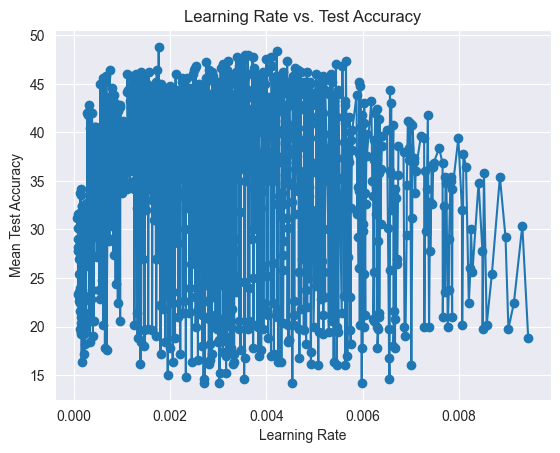

In [5]:
# Group by learning rate and compute mean test accuracy
lr_comparison = combined_df.groupby('learning_rate')['test_accuracy'].mean().reset_index()

# Plot learning rate vs. test accuracy
plt.plot(lr_comparison['learning_rate'], lr_comparison['test_accuracy'], 'o-')
plt.xlabel('Learning Rate')
plt.ylabel('Mean Test Accuracy')
plt.title('Learning Rate vs. Test Accuracy')
plt.show()

In [6]:
def extract_info(run_name):
    parts = run_name.split("_")
    if len(parts) == 4:  # Format: resnet20_{curriculum type}_hptuning_{date}
        model_type = "no_attention"  # No attention mechanism
        curriculum_type = parts[1]  # Curriculum type is the second part
    elif len(parts) >= 5:  # Format: resnet20_{model type}_{curriculum type}_hptuning_{date}
        model_type = parts[1]  # Model type is the second part
        curriculum_type = parts[2]  # Curriculum type is the third part
    else:
        model_type, curriculum_type = None, None  # Handle invalid run names
    return model_type, curriculum_type

# Apply the function to create new columns
combined_df[["model_type", "curriculum_type"]] = combined_df["run_name"].apply(
    lambda x: pd.Series(extract_info(x))
)

# Check the result
print(combined_df[["run_name", "model_type", "curriculum_type"]].head())

                                          run_name model_type curriculum_type
0  resnet20_cbam_curriculum_hptuning_1740485023569       cbam      curriculum
1  resnet20_cbam_curriculum_hptuning_1740485023569       cbam      curriculum
2  resnet20_cbam_curriculum_hptuning_1740485023569       cbam      curriculum
3  resnet20_cbam_curriculum_hptuning_1740485023569       cbam      curriculum
4  resnet20_cbam_curriculum_hptuning_1740485023569       cbam      curriculum


In [7]:
import numpy as np
# Example: Get final test accuracy and average difficulty per run
run_level_data = combined_df.groupby("run_id").agg(
    test_accuracy=("test_accuracy", "last"),
    avg_difficulty=("avg_difficulty", "mean"),
    curriculum_type=("curriculum_type", "first"),  # Assume curriculum type is constant per run
    attention_type=("model_type", "first"),
    learning_rate=("learning_rate", "first"),
).reset_index()


In [8]:
run_level_data

,run_id,test_accuracy,avg_difficulty,curriculum_type,attention_type,learning_rate
0,0an35lzm,43.2,1.399041,curriculum,mhattn,0.008279
1,135dxi5c,38.4,1.539499,anti-curriculum,mhattn,0.006639
2,1bcnd6hx,39.0,1.535211,anti-curriculum,mhattn,0.004685
3,1p6hq6ze,43.8,1.385981,curriculum,no_attention,0.003354
4,1ysriqfo,37.2,1.606975,anti-curriculum,selfattn,0.003723
...,...,...,...,...,...,...
68,wh87r29l,31.4,1.442503,curriculum,selfattn,0.000417
69,wmsc687w,44.4,1.372129,curriculum,no_attention,0.004846
70,xo1p11fc,38.8,1.661444,anti-curriculum,selfattn,0.004709
71,ynscebv8,42.4,1.575123,anti-curriculum,selfattn,0.007767


In [9]:
summary_stats = run_level_data.groupby(["curriculum_type", "attention_type"]).agg(
    mean_test_accuracy=("test_accuracy", "mean"),
    std_test_accuracy=("test_accuracy", "std"),
    n_runs=("test_accuracy", "count"),
).reset_index()
summary_stats

,curriculum_type,attention_type,mean_test_accuracy,std_test_accuracy,n_runs
0,anti-curriculum,cbam,38.720000,8.290932,10
1,anti-curriculum,mhattn,40.480000,2.740803,5
2,anti-curriculum,no_attention,41.600000,6.557100,10
3,anti-curriculum,selfattn,37.123077,5.830116,13
4,curriculum,cbam,43.740000,3.193118,10
5,curriculum,mhattn,41.760000,2.769115,5
6,curriculum,no_attention,44.640000,1.892206,10
7,curriculum,selfattn,39.320000,4.977460,10


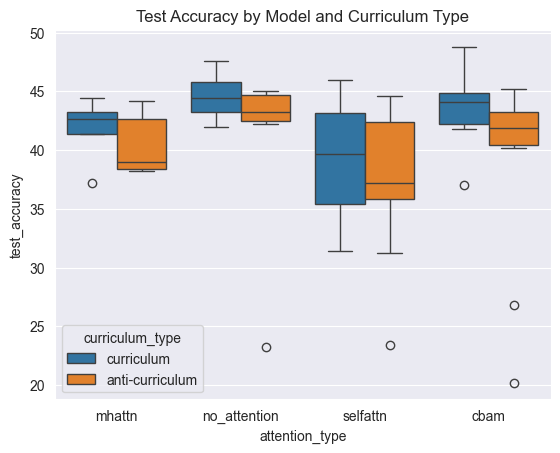

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# Box plot of test accuracy by model type and curriculum type
sns.boxplot(
    data=run_level_data,
    x="attention_type",
    y="test_accuracy",
    hue="curriculum_type"
)
plt.title("Test Accuracy by Model and Curriculum Type")
plt.show()

In [42]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Factorial ANOVA to test for main and interaction effects
model = ols(
    "test_accuracy ~ C(attention_type) + C(curriculum_type) + C(attention_type):C(curriculum_type)",
    data=run_level_data
).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

                                           sum_sq    df         F    PR(>F)
C(attention_type)                      257.739071   3.0  3.066329  0.034037
C(curriculum_type)                     172.252352   1.0  6.147873  0.015759
C(attention_type):C(curriculum_type)    31.333702   3.0  0.372778  0.772903
Residual                              1821.183077  65.0       NaN       NaN


In [47]:
from scipy import stats

# Example: Compare curriculum types
groups = [group["test_accuracy"] for name, group in run_level_data.groupby("attention_type")]
f_stat, p_value = stats.f_oneway(*groups)  # ANOVA
f_stat, p_value

(np.float64(3.20884498697264), np.float64(0.028300031293126564))

In [48]:
# If data is non-normal or variances are unequal:
h_stat, p_value = stats.kruskal(*groups)  # Kruskal-Wallis
h_stat, p_value

(np.float64(15.272095113229398), np.float64(0.001598287875997119))

In [49]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

tukey = pairwise_tukeyhsd(
    endog=run_level_data["test_accuracy"],
    groups=run_level_data["attention_type"],
    alpha=0.05
)
print(tukey.summary())

      Multiple Comparison of Means - Tukey HSD, FWER=0.05       
   group1       group2    meandiff p-adj   lower   upper  reject
----------------------------------------------------------------
        cbam       mhattn    -0.11 0.9999 -5.6336  5.4136  False
        cbam no_attention     1.89 0.6887   -2.62     6.4  False
        cbam     selfattn  -3.1517 0.2363 -7.5122  1.2087  False
      mhattn no_attention      2.0 0.7762 -3.5236  7.5236  False
      mhattn     selfattn  -3.0417 0.4535 -8.4439  2.3604  False
no_attention     selfattn  -5.0417  0.017 -9.4022 -0.6813   True
----------------------------------------------------------------


In [50]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

model = ols(
    "test_accuracy ~ C(curriculum_type) + C(attention_type) + C(curriculum_type):C(attention_type)",
    data=run_level_data
).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

                                           sum_sq    df         F    PR(>F)
C(curriculum_type)                     172.252352   1.0  6.147873  0.015759
C(attention_type)                      257.739071   3.0  3.066329  0.034037
C(curriculum_type):C(attention_type)    31.333702   3.0  0.372778  0.772903
Residual                              1821.183077  65.0       NaN       NaN


In [51]:
import statsmodels.formula.api as smf

model = smf.ols("test_accuracy ~ curriculum_type + attention_type + learning_rate", data=run_level_data).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          test_accuracy   R-squared:                       0.268
Model:                            OLS   Adj. R-squared:                  0.213
Method:                 Least Squares   F-statistic:                     4.904
Date:                Fri, 28 Feb 2025   Prob (F-statistic):           0.000696
Time:                        17:39:22   Log-Likelihood:                -218.25
No. Observations:                  73   AIC:                             448.5
Df Residuals:                      67   BIC:                             462.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

In [53]:
# Eta squared is the proportion of the total variance that is attributed to an effect
eta_sq = anova_table["sum_sq"][0] / (anova_table["sum_sq"][0] + anova_table["sum_sq"][-1])
eta_sq

C:\Users\luay8\AppData\Local\Temp\ipykernel_22032\137529490.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  eta_sq = anova_table["sum_sq"][0] / (anova_table["sum_sq"][0] + anova_table["sum_sq"][-1])


np.float64(0.08640979762532125)

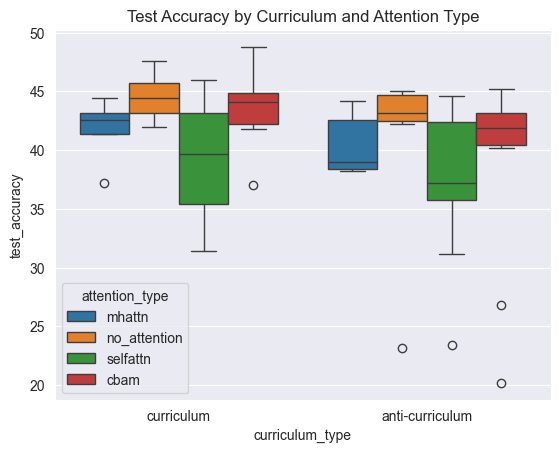

In [11]:
import seaborn as sns

sns.boxplot(
    data=run_level_data,
    x="curriculum_type",
    y="test_accuracy",
    hue="attention_type"
)
plt.title("Test Accuracy by Curriculum and Attention Type")
plt.show()

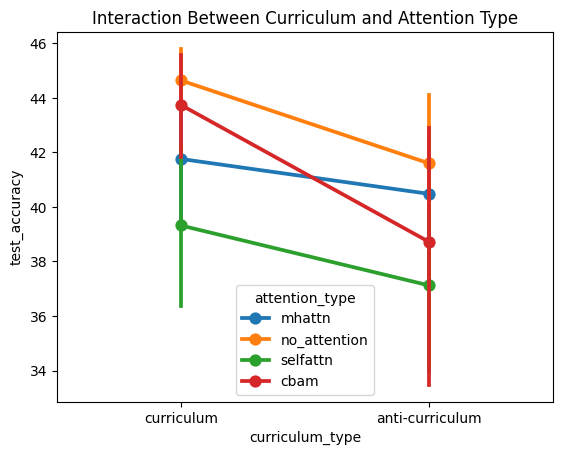

In [102]:
sns.pointplot(
    data=run_level_data,
    x="curriculum_type",
    y="test_accuracy",
    hue="attention_type",
    errorbar=('ci', 95)  # 95% confidence intervals
)
plt.title("Interaction Between Curriculum and Attention Type")
plt.show()

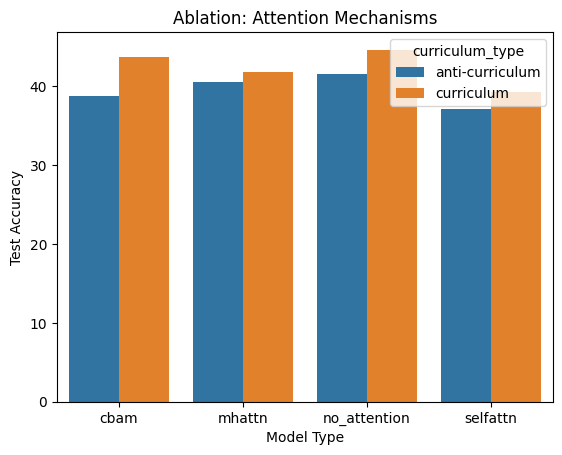

In [101]:
import seaborn as sns

# Group data by attention type and curriculum
ablation_data = run_level_data.groupby(["attention_type", "curriculum_type"]).agg(
    mean_test_accuracy=("test_accuracy", "mean"),
    std_test_accuracy=("test_accuracy", "std"),
).reset_index()

# Plot
sns.barplot(
    data=ablation_data,
    x="attention_type",
    y="mean_test_accuracy",
    hue="curriculum_type",
    errorbar="sd"  # Show standard deviation
)
plt.title("Ablation: Attention Mechanisms")
plt.ylabel("Test Accuracy")
plt.xlabel("Model Type")
plt.show()

Curriculum vs. Anti-Curriculum: t = 2.57, p = 0.0121


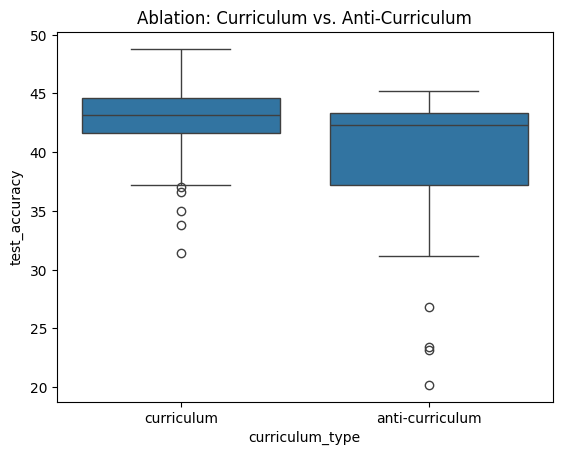

In [100]:
from scipy import stats

# Compare curriculum vs. anti-curriculum for all models
curriculum_acc = run_level_data[run_level_data["curriculum_type"] == "curriculum"]["test_accuracy"]
anti_curriculum_acc = run_level_data[run_level_data["curriculum_type"] == "anti-curriculum"]["test_accuracy"]

# T-test
t_stat, p_value = stats.ttest_ind(curriculum_acc, anti_curriculum_acc)
print(f"Curriculum vs. Anti-Curriculum: t = {t_stat:.2f}, p = {p_value:.4f}")

# Boxplot
sns.boxplot(
    x=run_level_data["curriculum_type"],
    y=run_level_data["test_accuracy"]
)
plt.title("Ablation: Curriculum vs. Anti-Curriculum")
plt.show()

## Error Analysis

In [2]:
from models.original_basic_block import OriginalBasicBlock       # No-attention model
from models.cifar10resnet import Cifar10ResNet
from models.resnet_cbam import ResnetCBAM           # CBAM attention model
from models.resnet_self_att import ResnetSelfAtt      # Self-Attention model
from models.resnet_multi_head_att import ResnetMultiHeadAtt

# Best Model: no_attention + curriculum (highest mean accuracy)
resnet_curriculum_path = r"C:\Users\luay8\DataspellProjects\deep_learning\finalproject\models\saved_models\resnet20_curriculum_hptuning_1740559360291_20250226-104243_20250226-104246_20250226-104246_20250226-104854.pth"

# Worst Model: selfattn + anti-curriculum (lowest mean accuracy)
self_attn_anti_path = r"C:\Users\luay8\DataspellProjects\deep_learning\finalproject\models\saved_models\resnet20_selfattn_anti-curriculum_hptuning_1740535808725_20250226-041011_20250226-041014_20250226-041014_20250226-043633.pth"

# Attention vs No-Attention: Compare cbam + curriculum vs no_attention + curriculum
cbam_curriculum_path = r"C:\Users\luay8\DataspellProjects\deep_learning\finalproject\models\saved_models\resnet20_cbam_curriculum_hptuning_1740486262963_20250225-142426_20250225-142429_20250225-142429_20250225-143121.pth"

#Curriculum vs Anti-Curriculum: Same model type (e.g., mhattn) with both curricula
cbam_anti_path = r"C:\Users\luay8\DataspellProjects\deep_learning\finalproject\models\saved_models\resnet20_cbam_anti-curriculum_hptuning_1740487645747_20250225-144729_20250225-144731_20250225-144731_20250225-145207.pth"



In [17]:

def show_class_examples(dataset, class_names, samples_per_class=1):
    """
    Displays one or more example images for each class from the dataset.

    Parameters:
        dataset: The dataset from which to draw examples (e.g., test_loader.dataset)
                 Each element should be a tuple (image, label, ...) where image is a tensor.
        class_names: List of class names corresponding to the dataset's numeric labels.
        samples_per_class: Number of examples to show per class.
    """
    # Create a dictionary to store examples for each class.
    examples = {i: [] for i in range(len(class_names))}

    # Iterate over the dataset and collect up to 'samples_per_class' images for each label.
    for sample in dataset:
        # Assume sample is (image, label, ...) where the first two entries are used.
        img, lbl = sample[0], sample[1]
        # If we don't yet have enough examples for this class, store the image.
        if len(examples[lbl]) < samples_per_class:
            examples[lbl].append(img)
        # If all classes have enough samples, we can break early.
        if all(len(examples[i]) >= samples_per_class for i in examples):
            break

    # Determine grid size for plotting.
    n_classes = len(class_names)
    fig, axes = plt.subplots(n_classes, samples_per_class, figsize=(samples_per_class * 3, n_classes * 3))

    # In case samples_per_class is 1, axes might be 1D instead of 2D.
    if samples_per_class == 1:
        axes = [[ax] for ax in axes]

    # Plot the examples.
    for cls in range(n_classes):
        for j in range(samples_per_class):
            ax = axes[cls][j]
            if j < len(examples[cls]):
                img = examples[cls][j]
                # If the image is a torch.Tensor, convert to a numpy array and permute dimensions.
                if isinstance(img, torch.Tensor):
                    img_np = img.permute(1, 2, 0).cpu().numpy()
                else:
                    img_np = img
                ax.imshow(img_np)
                ax.set_title(f"{class_names[cls]} (Label: {cls})")
                ax.axis("off")
            else:
                ax.axis("off")
    plt.tight_layout()
    plt.show()


In [10]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

CLASS_NAMES = ["hamster", "mouse", "rabbit", "shrew", "squirrel"]

def get_test_loader(dataset_name="cifar100_subset_16", batch_size=128):
    from d_run_full_exp import PrepareData, IndexedDatasetWrapper
    data_prep = PrepareData(dataset_name=dataset_name, superclass_idx=16)
    test_dataset = IndexedDatasetWrapper(data_prep.get_test_dataset())
    return torch.utils.data.DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
        pin_memory=True
    )

test_loader = get_test_loader()

def load_model(model_path, model_class, device="cuda"):
    """Load a model checkpoint into an instance of model_class."""
    checkpoint = torch.load(model_path)
    model = model_class(OriginalBasicBlock, [3, 3, 3], num_classes=5)  # Adjust if needed
    model.load_state_dict(checkpoint["model_state_dict"])
    return model.eval().to(device)

Loaded dataset from datasets/saved_data_files/cifar100_subset16_5classes_train.pt and datasets/saved_data_files/cifar100_subset16_5classes_test.pt.


C:\Users\luay8\AppData\Local\Temp\ipykernel_19696\2782558431.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)
C:\Users\luay8\AppData\

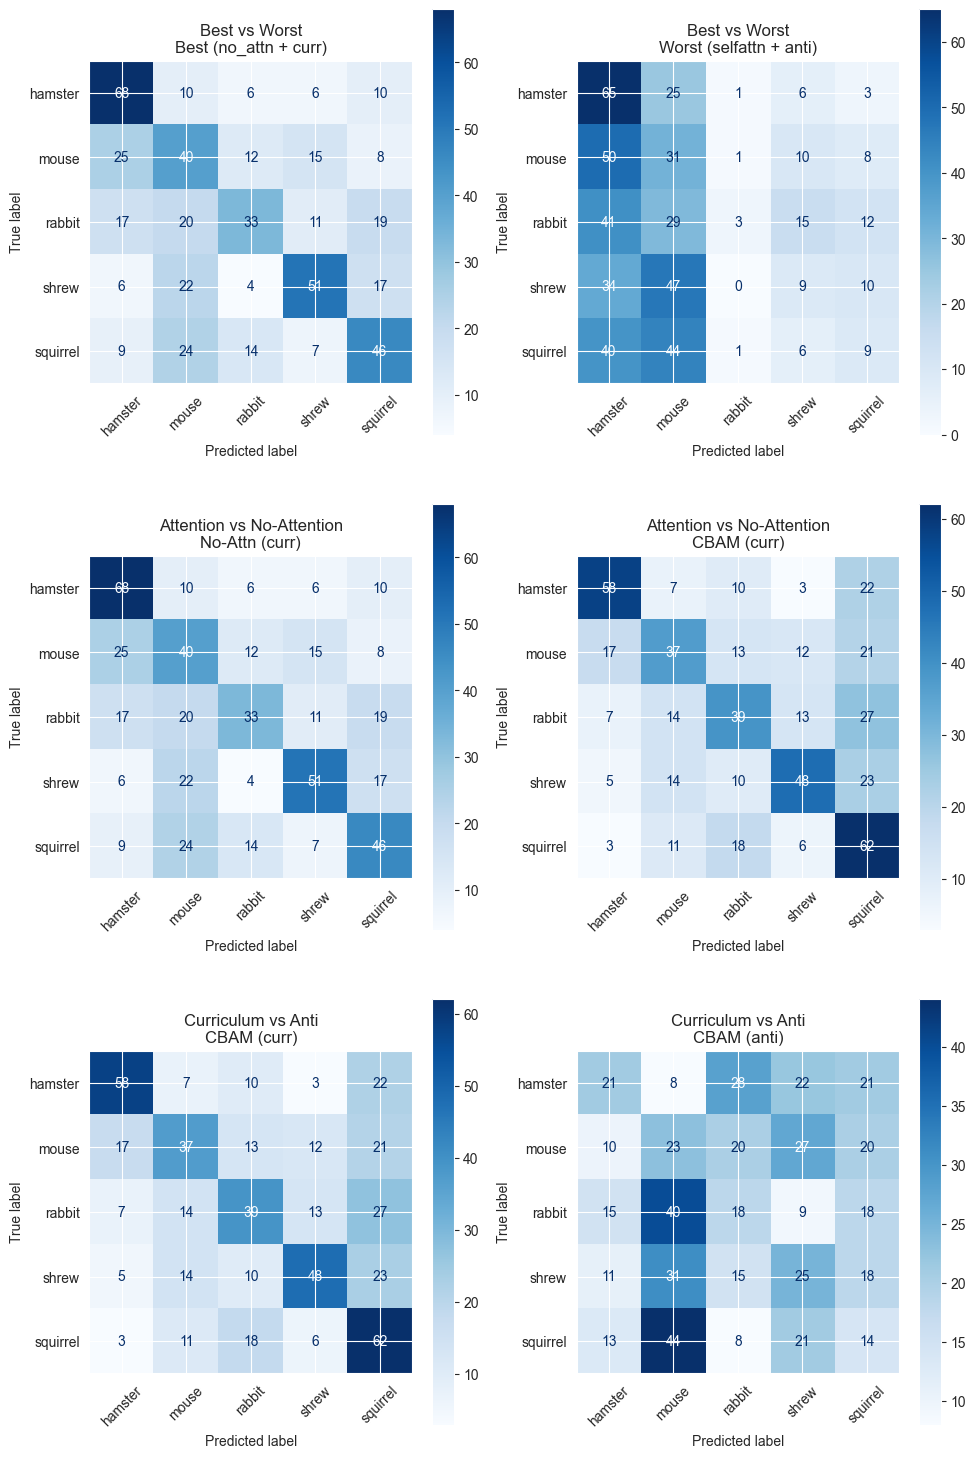

In [11]:

def analyze_errors(model, test_loader, class_names, device="cuda"):
    """Return confusion matrix for a loaded model on the test set."""
    model.eval().to(device)
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, labels, _ in test_loader:
            images = images.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    cm = confusion_matrix(y_true, y_pred)
    return cm
cm_df = []
def combined_confusion_matrices(comparisons, test_loader, class_names, device="cuda"):
    """
    Plots a single figure with multiple rows.
    Each entry in 'comparisons' is a tuple: (title_for_this_row, model_info_dict)
    where model_info_dict has {ModelName: (model_path, model_class), ...} for 2 models.
    """
    global cm_df
    n_rows = len(comparisons)
    fig, axes = plt.subplots(n_rows, 2, figsize=(10, 5 * n_rows))
    if n_rows == 1:
        axes = [axes]  # Make it 2D if there's only one comparison

    for row_idx, (comparison_title, model_info) in enumerate(comparisons):
        # model_info is a dict with exactly 2 models for side-by-side comparison
        model_names = list(model_info.keys())
        # Ensure we have 2 columns:
        for col_idx, model_name in enumerate(model_names):
            model_path, model_class = model_info[model_name]
            model = load_model(model_path, model_class, device)
            cm = analyze_errors(model, test_loader, class_names, device)
            cm_df.append(cm)
            disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
            ax = axes[row_idx][col_idx]
            disp.plot(ax=ax, cmap="Blues", xticks_rotation=45)
            ax.set_title(f"{comparison_title}\n{model_name}")
    plt.tight_layout()
    plt.show()

# --- Define your 3 comparisons ---
comparisons = [
    (
        "Best vs Worst",
        {
            "Best (no_attn + curr)": (resnet_curriculum_path, Cifar10ResNet),
            "Worst (selfattn + anti)": (self_attn_anti_path, ResnetSelfAtt)
        }
    ),
    (
        "Attention vs No-Attention",
        {
            "No-Attn (curr)": (resnet_curriculum_path, Cifar10ResNet),
            "CBAM (curr)": (cbam_curriculum_path, ResnetCBAM)
        }
    ),
    (
        "Curriculum vs Anti",
        {
            "CBAM (curr)": (cbam_curriculum_path, ResnetCBAM),
            "CBAM (anti)": (cbam_anti_path, ResnetCBAM)
        }
    )
]

# Plot all comparisons in one figure
combined_confusion_matrices(comparisons, test_loader, CLASS_NAMES, device="cuda")


In [7]:
print(cm_df)

[array([[68, 10,  6,  6, 10],
       [25, 40, 12, 15,  8],
       [17, 20, 33, 11, 19],
       [ 6, 22,  4, 51, 17],
       [ 9, 24, 14,  7, 46]]), array([[65, 25,  1,  6,  3],
       [50, 31,  1, 10,  8],
       [41, 29,  3, 15, 12],
       [34, 47,  0,  9, 10],
       [40, 44,  1,  6,  9]]), array([[68, 10,  6,  6, 10],
       [25, 40, 12, 15,  8],
       [17, 20, 33, 11, 19],
       [ 6, 22,  4, 51, 17],
       [ 9, 24, 14,  7, 46]]), array([[58,  7, 10,  3, 22],
       [17, 37, 13, 12, 21],
       [ 7, 14, 39, 13, 27],
       [ 5, 14, 10, 48, 23],
       [ 3, 11, 18,  6, 62]]), array([[58,  7, 10,  3, 22],
       [17, 37, 13, 12, 21],
       [ 7, 14, 39, 13, 27],
       [ 5, 14, 10, 48, 23],
       [ 3, 11, 18,  6, 62]]), array([[21,  8, 28, 22, 21],
       [10, 23, 20, 27, 20],
       [15, 40, 18,  9, 18],
       [11, 31, 15, 25, 18],
       [13, 44,  8, 21, 14]])]


In [30]:
import random
def generate_saliency_map(model, image, target_class, device="cuda"):
    """Generate gradient-based saliency map for a single image."""
    model.eval()
    image = image.to(device).requires_grad_()
    output = model(image.unsqueeze(0))
    output[0, target_class].backward()

    # Absolute value of gradients -> shape (3, H, W)
    saliency = torch.abs(image.grad.data)

    # Collapse across channels by taking max over channels
    saliency, _ = saliency.max(dim=0)

    # Normalize [0, 1]
    saliency = (saliency - saliency.min()) / (saliency.max() - saliency.min() + 1e-8)
    return saliency.cpu().numpy()

def compare_saliency_maps_with_original(model_info, test_loader, class_names, num_images=5, device="cuda"):
    """
     Creates a grid of (1 + M) rows x (num_images) columns:
       - Top row: original images with true labels.
       - Next M rows: for each model in 'model_info', display its saliency map for the image,
         with the title showing the model name, the true label, and the predicted label.
     
     Parameters:
       model_info (dict): Keys are model names, values are tuples (model_path, model_class).
       test_loader: DataLoader for the test dataset.
       class_names (list): List of class names.
       num_images (int): Number of images to display (randomly selected).
       device (str): Device to use ("cuda" or "cpu").
     """
    # Collect a small batch of images from the dataset
    samples = []
    img_idx = [283, 306, 208, 453, 489]
    for i in img_idx:
        img, lbl, _ = test_loader.dataset[i]
        samples.append((img, lbl))
    
    # # Collect a random batch of images from the dataset
    # samples = []
    # indices = random.sample(range(len(test_loader.dataset)), num_images)  # Randomly select indices
    # for i in indices:
    #     img, lbl, _ = test_loader.dataset[i]
    #     samples.append((img, lbl))

    # # Collect one random image per class
    # samples = []
    # class_indices = {cls: [] for cls in range(len(CLASS_NAMES))}  # Dictionary to store indices for each class
    # 
    # # First, categorize dataset indices by class
    # for i in range(len(test_loader.dataset)):
    #     _, lbl, _ = test_loader.dataset[i]
    #     class_indices[lbl].append(i)
    # 
    # # Now, randomly select one sample from each class
    # for cls in class_indices:
    #     if class_indices[cls]:  # Ensure there are samples available
    #         selected_idx = random.choice(class_indices[cls])  # Randomly pick one from that class
    #         img, lbl, _ = test_loader.dataset[selected_idx]
    #         samples.append((img, lbl))

    # Prepare figure
    # Figure setup
    n_models = len(model_info)
    fig, axes = plt.subplots(n_models + 1, num_images, figsize=(3 * num_images, 3 * (n_models + 1)))

    # Ensure axes is 2D
    if (n_models + 1) == 1:
        axes = [axes]
    if num_images == 1:
        axes = [[ax] for ax in axes]

    # --- Top row: Original Images ---
    for col_idx, (img, lbl) in enumerate(samples):
        ax = axes[0][col_idx]
        ax.imshow(img.permute(1, 2, 0).cpu().numpy())
        ax.set_title(f"Original\n{class_names[lbl]}")
        ax.axis("off")

    # Load all models
    loaded_models = {}
    for model_name, (model_path, model_class) in model_info.items():
        loaded_models[model_name] = load_model(model_path, model_class, device)

    # --- Next rows: Overlay saliency on the original image ---
    for row_idx, (model_name, model) in enumerate(loaded_models.items(), start=1):
        for col_idx, (img, lbl) in enumerate(samples):
            # Generate saliency map
            saliency = generate_saliency_map(model, img, lbl, device)

            # Get the model's prediction
            model.eval()
            with torch.no_grad():
                output = model(img.to(device).unsqueeze(0))
                pred_idx = torch.argmax(output, dim=1).item()

            # Convert image to NumPy
            img_np = img.permute(1, 2, 0).cpu().numpy()

            # Display: Original image in the background, saliency as an overlay
            ax = axes[row_idx][col_idx]
            ax.imshow(img_np, alpha=1.0)                # Full opacity for the background
            ax.imshow(saliency, cmap="inferno", alpha=0.75)  # Semi-transparent saliency overlay
            ax.set_title(f"{model_name}\nTrue: {class_names[lbl]}\nPred: {class_names[pred_idx]}")
            ax.axis("off")

    plt.tight_layout()
    plt.show()

# Example usage for saliency across all 4 models:
model_info_saliency = {
    "No-Attn (curr)": (resnet_curriculum_path, Cifar10ResNet),
    "CBAM (curr)": (cbam_curriculum_path, ResnetCBAM),
    "SelfAttn (anti)": (self_attn_anti_path, ResnetSelfAtt),
    "CBAM (anti)": (cbam_anti_path, ResnetCBAM)
}
# 
# compare_saliency_maps_with_original(model_info_saliency, test_loader, CLASS_NAMES, num_images=20, device="cuda")


In [31]:
from models.original_basic_block import OriginalBasicBlock       # No-attention model
from models.cifar10resnet import Cifar10ResNet
from models.resnet_cbam import ResnetCBAM           # CBAM attention model
from models.resnet_self_att import ResnetSelfAtt      # Self-Attention model
from models.resnet_multi_head_att import ResnetMultiHeadAtt

# --- File paths for models ---
resnet_curriculum_path = "models/saved_models/resnet20_curriculum_hptuning_1740559360291_20250226-104243_20250226-104246_20250226-104246_20250226-104854.pth"
resnet_anti_path = "models/saved_models/resnet20_anti-curriculum_hptuning_1740566289548_20250226-123813_20250226-123815_20250226-123815_20250226-124416.pth"


self_attn_curriculum_path = "models/saved_models/resnet20_selfattn_curriculum_hptuning_1740512546492_20250225-214230_20250225-214233_20250225-214233_20250225-220328.pth"

self_attn_anti_path    = "models/saved_models/resnet20_selfattn_anti-curriculum_hptuning_1740535808725_20250226-041011_20250226-041014_20250226-041014_20250226-043633.pth"


cbam_curriculum_path   = "models/saved_models/resnet20_cbam_curriculum_hptuning_1740486262963_20250225-142426_20250225-142429_20250225-142429_20250225-143121.pth"
cbam_anti_path         = "models/saved_models/resnet20_cbam_anti-curriculum_hptuning_1740487645747_20250225-144729_20250225-144731_20250225-144731_20250225-145207.pth"


mhattn_curriculum_path = "models/saved_models/resnet20_mhattn_curriculum_hptuning_1740584023305_20250226-173347_20250226-173350_20250226-173350_20250226-180004.pth"
mhattn_anti_path = "models/saved_models/resnet20_mhattn_anti-curriculum_hptuning_1740590910714_20250226-192834_20250226-192837_20250226-192837_20250226-195708.pth"

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8974658..1.9969461].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4544886..2.025353].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7140007..1.4572157].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.3929366..2.025353].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.3266578..1.6036617].
C:\Users\luay8\AppData\Local\Temp\ipykernel_19696\2782558431.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will ex

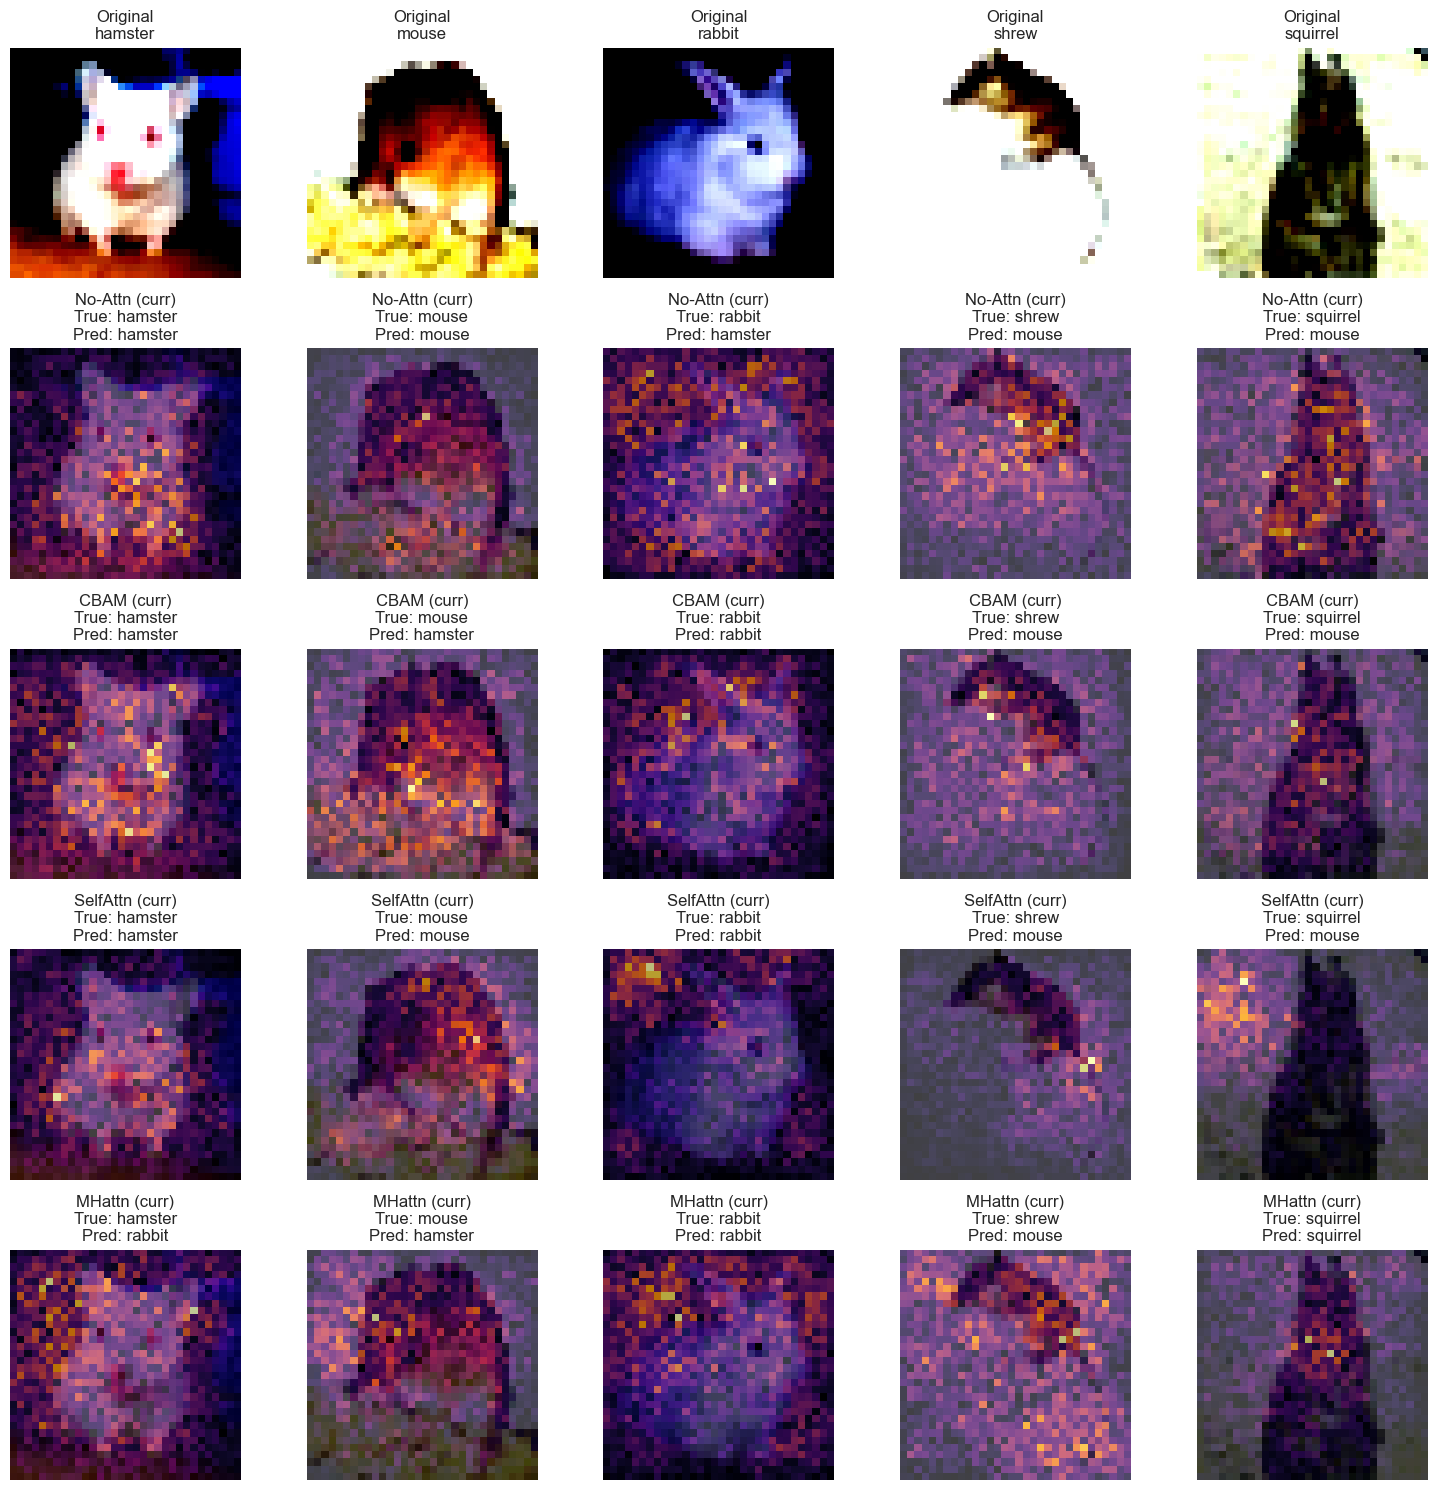

In [32]:
model_info_saliency = {
    "No-Attn (curr)": (resnet_curriculum_path, Cifar10ResNet),
    "CBAM (curr)": (cbam_curriculum_path, ResnetCBAM),
    "SelfAttn (curr)": (self_attn_curriculum_path, ResnetSelfAtt),
    "MHattn (curr)": (mhattn_curriculum_path, ResnetMultiHeadAtt)
}

compare_saliency_maps_with_original(model_info_saliency, test_loader, CLASS_NAMES, num_images=5, device="cuda")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8974658..1.9969461].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4544886..2.025353].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7140007..1.4572157].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.3929366..2.025353].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.3266578..1.6036617].
C:\Users\luay8\AppData\Local\Temp\ipykernel_19696\2782558431.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will ex

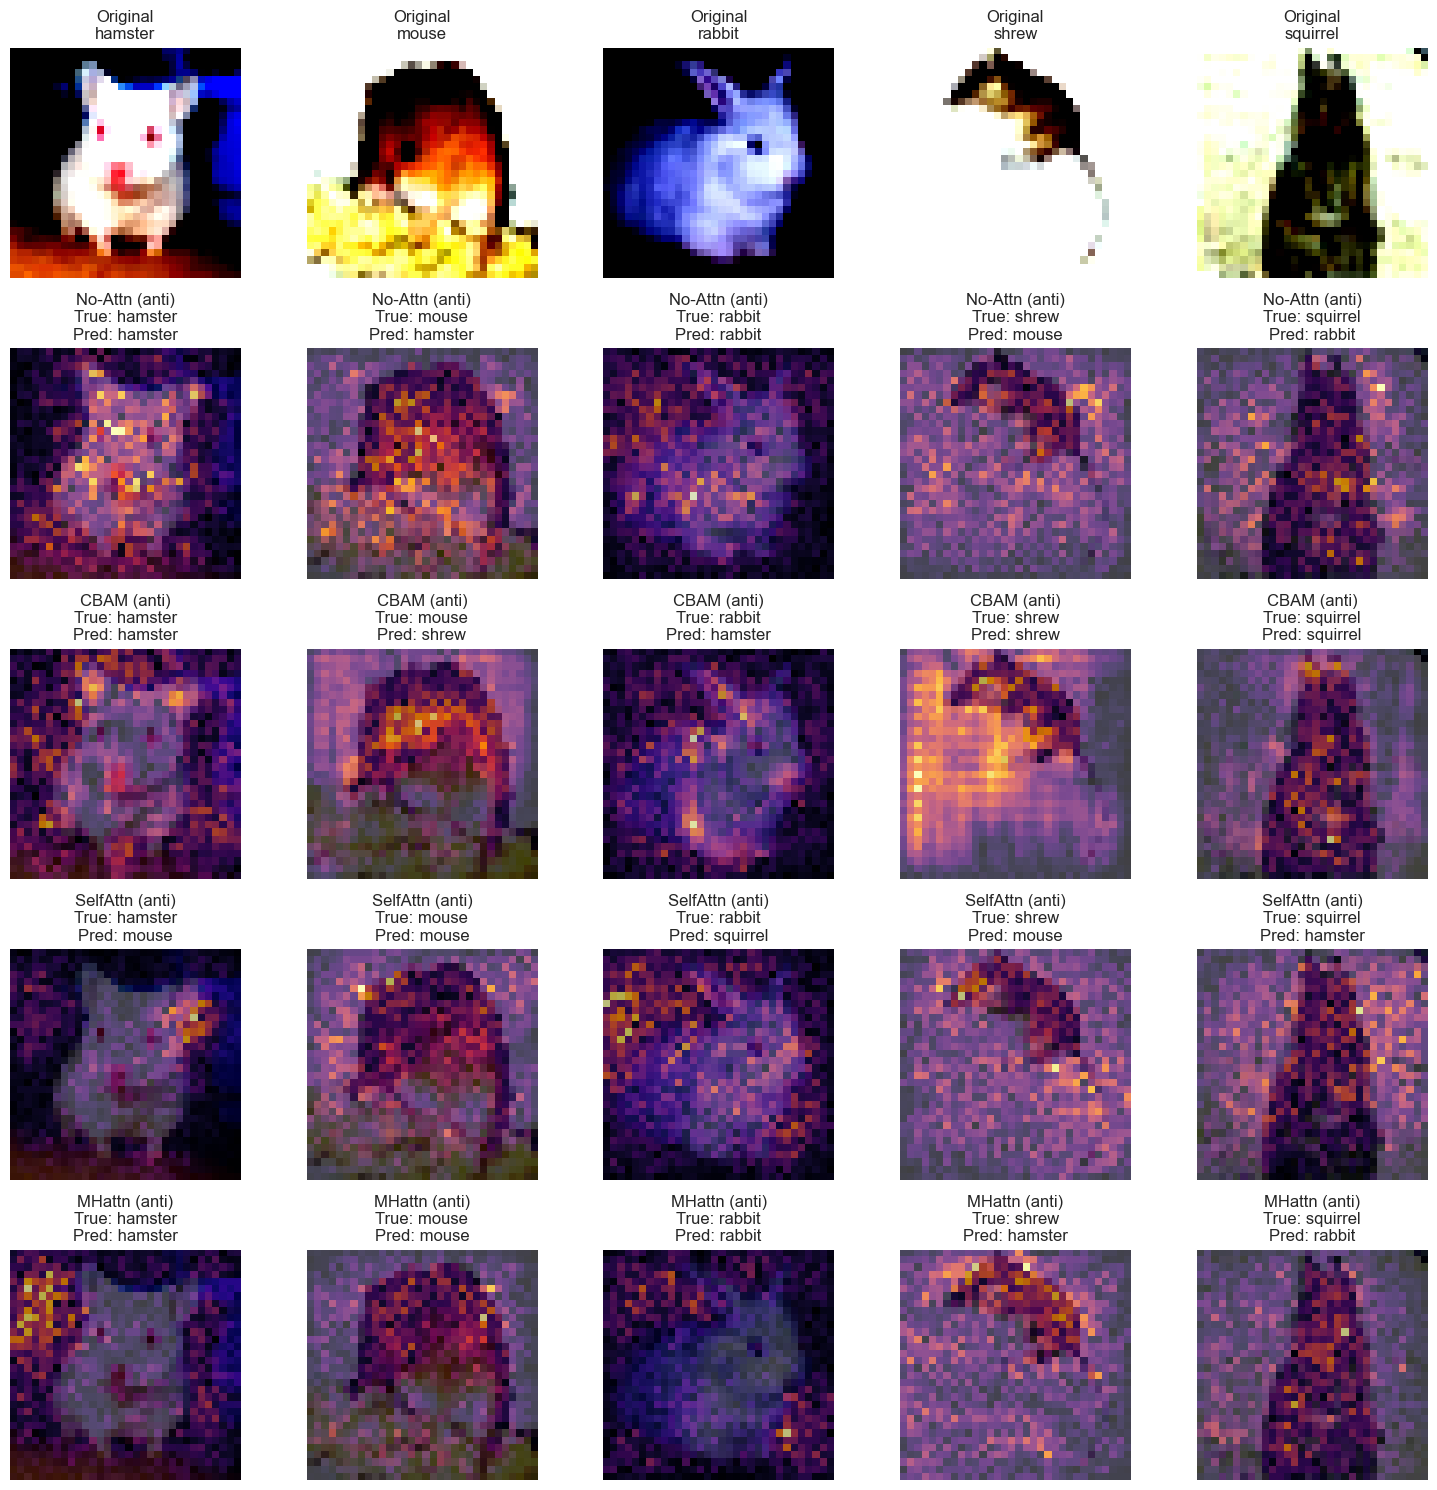

In [33]:
model_info_saliency = {
    "No-Attn (anti)": (resnet_anti_path, Cifar10ResNet),
    "CBAM (anti)": (cbam_anti_path, ResnetCBAM),
    "SelfAttn (anti)": (self_attn_anti_path, ResnetSelfAtt),
    "MHattn (anti)": (mhattn_anti_path, ResnetMultiHeadAtt)
}

compare_saliency_maps_with_original(model_info_saliency, test_loader, CLASS_NAMES, num_images=5, device="cuda")

Loaded dataset from datasets/saved_data_files/cifar100_subset16_5classes_train.pt and datasets/saved_data_files/cifar100_subset16_5classes_test.pt.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4082253..1.4174749].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5764017..2.025353].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7637602..1.4572157].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6611397..1.9401324].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4852189..2.025353].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6024995..1.7838947].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8668883.

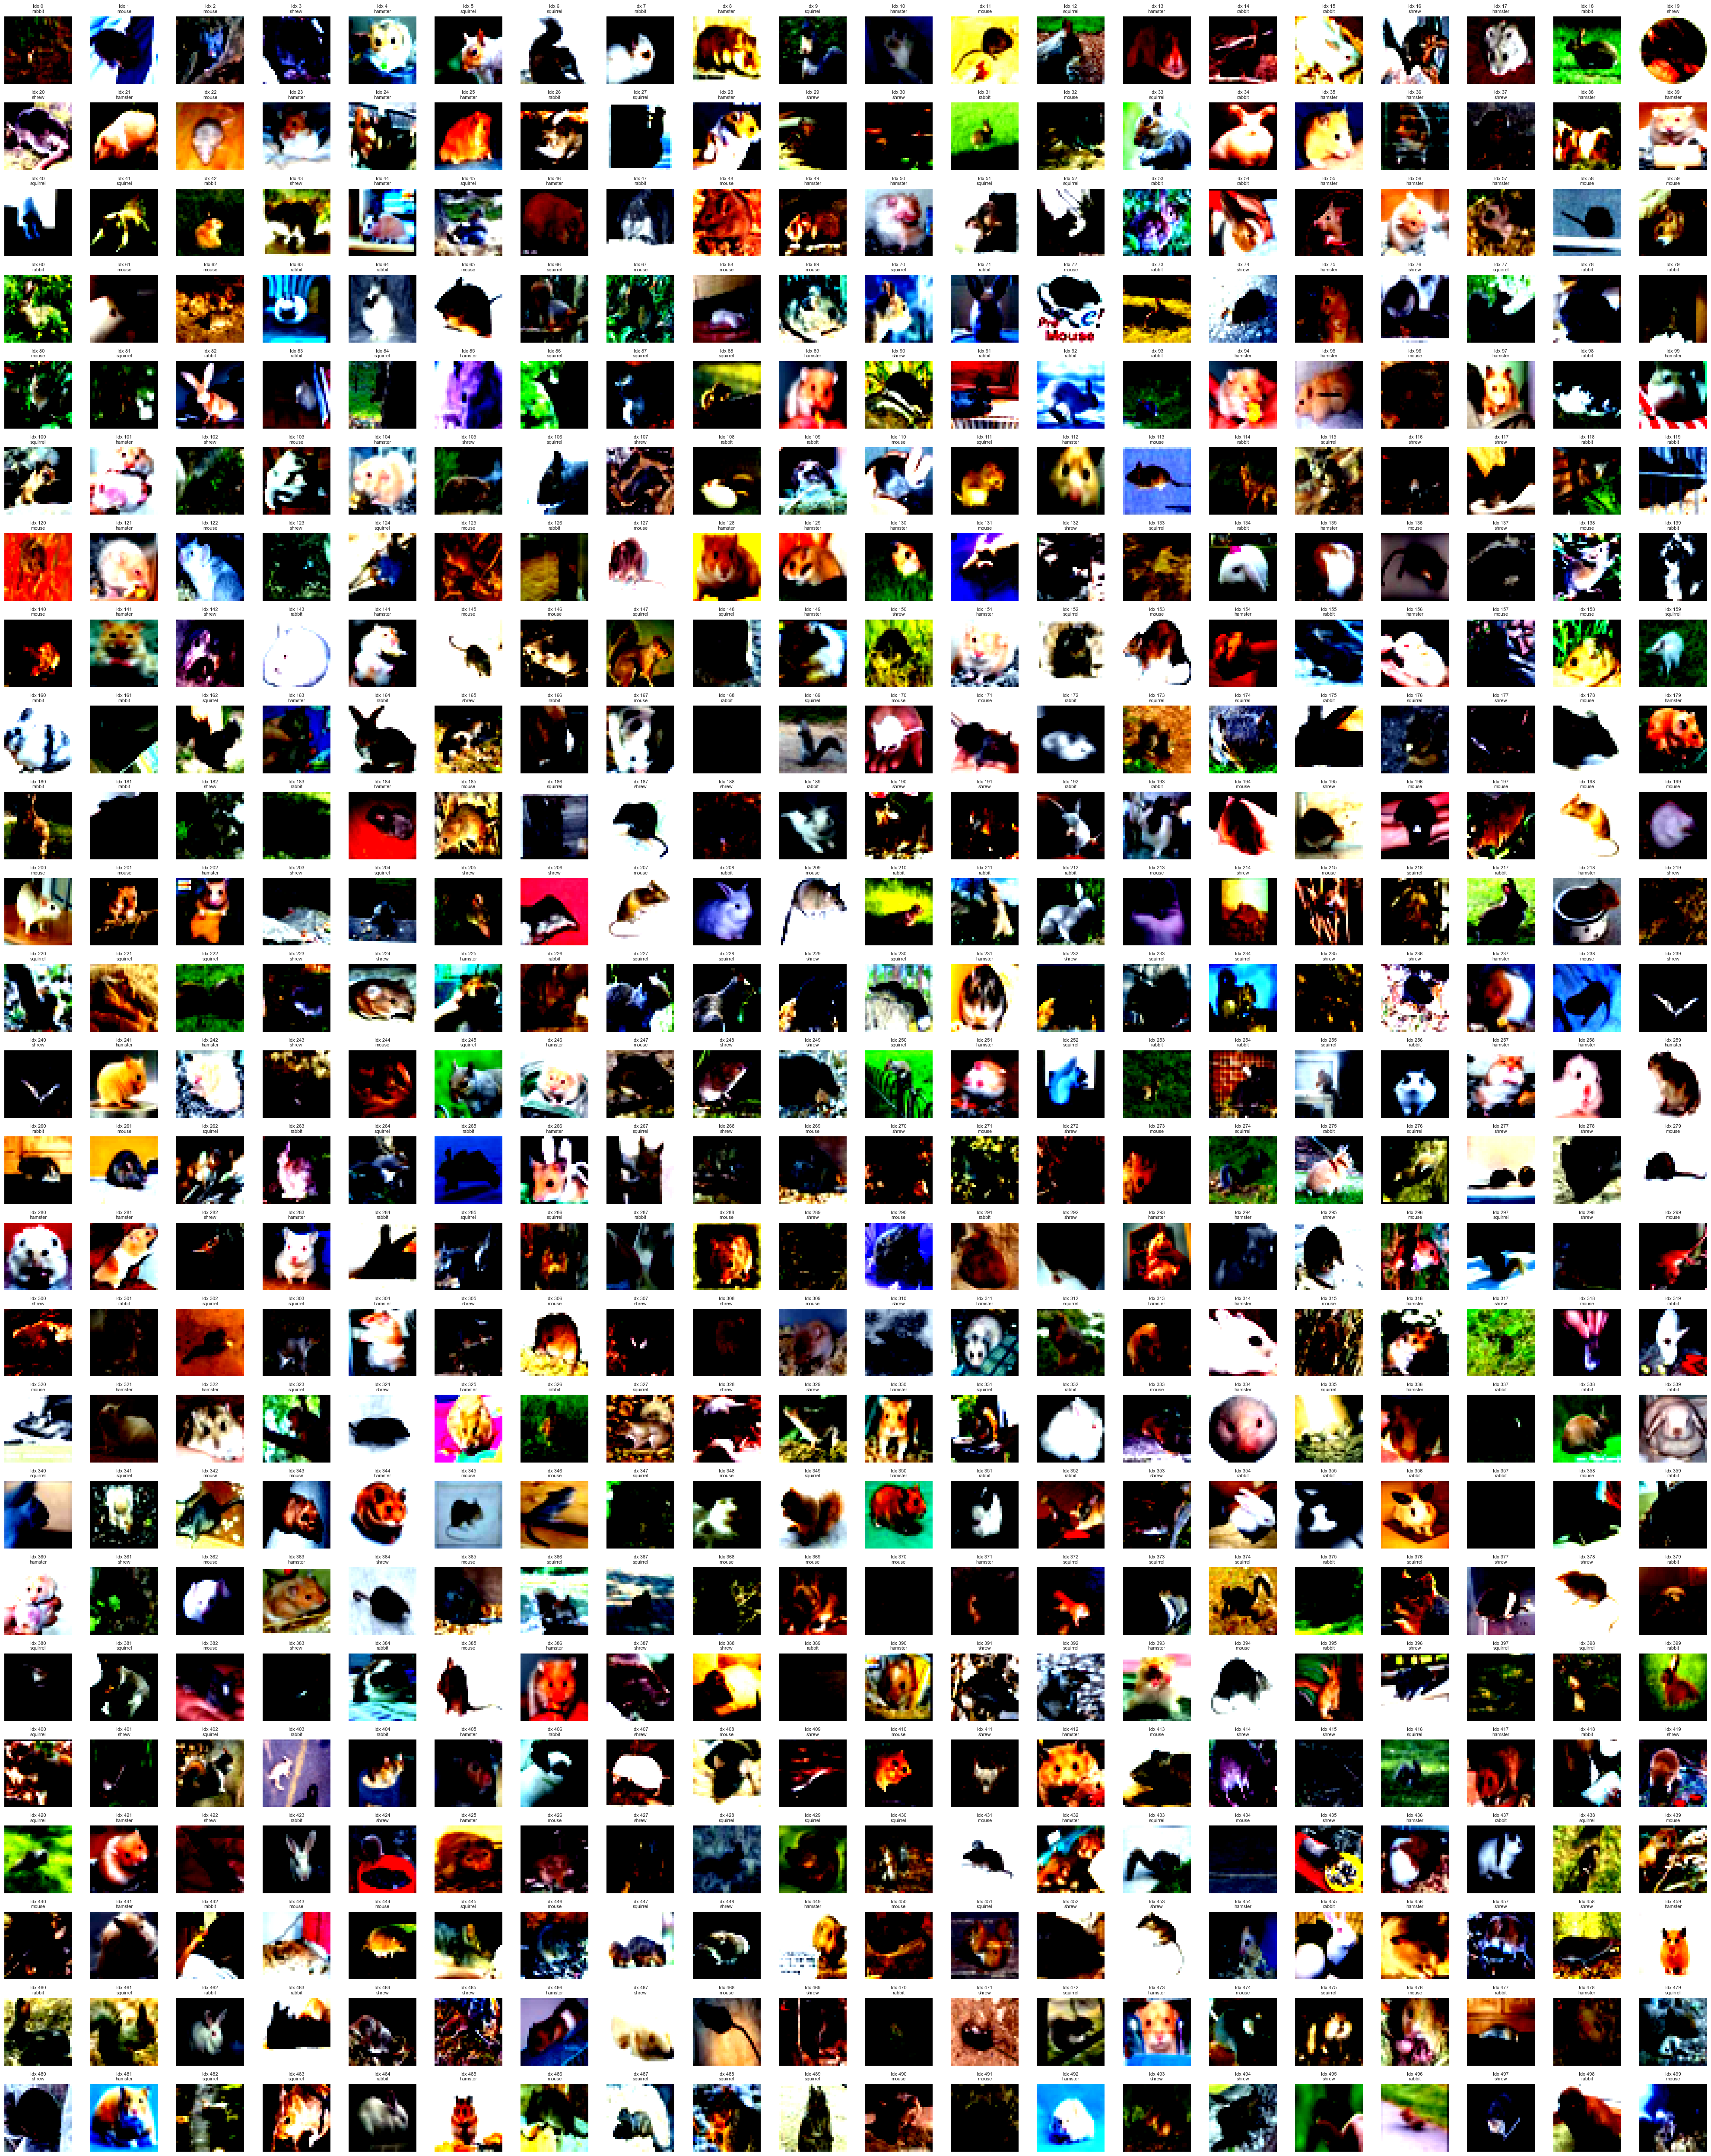

ModuleNotFoundError: No module named 'ace_tools'

In [39]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Load the test dataset
test_loader = get_test_loader()
dataset = test_loader.dataset  # Extract the dataset from the DataLoader

# Extract all images and labels
num_samples = len(dataset)
images, labels, indices = [], [], []

for i in range(num_samples):
    img, lbl, _ = dataset[i]
    images.append(img)
    labels.append(lbl)
    indices.append(i)

# Convert labels to class names
label_names = [CLASS_NAMES[lbl] for lbl in labels]

# Determine the grid size for visualization
num_cols = 20  # Define how many images per row
num_rows = int(np.ceil(num_samples / num_cols))  # Compute necessary rows

# Create figure
fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 2, num_rows * 2))

# Loop through images and plot them
for idx, (img, lbl, ax) in enumerate(zip(images, label_names, axes.flat)):
    ax.imshow(img.permute(1, 2, 0).numpy())  # Convert to (H, W, C) format
    ax.set_title(f"Idx {indices[idx]}\n{lbl}", fontsize=8)
    ax.axis("off")

# Hide any unused subplots
for ax in axes.flat[num_samples:]:
    ax.axis("off")

plt.tight_layout()
plt.show()

# Convert data to a structured format
import pandas as pd
df = pd.DataFrame({"Index": indices, "Class Name": label_names})

# Display the dataframe
import ace_tools as tools
tools.display_dataframe_to_user(name="CIFAR-100 Mammals Subset Index", dataframe=df)
